# Photoluminescence Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as sp
import scipy.constants as phys
from scipy.optimize import curve_fit

from bric_analysis_libraries import standard_functions as std

In [1]:
def normalize( df ):
    """
    Normalize all spectrum
    
    :param df: The Pandas DataFrame to normalize
    :returns: The normalized DataFrame
    """
    return df.apply( lambda x: x/ x.max() )


def fwhm( df ):
    """
    Calculates the full width at half max (fwhm)
    
    :param df: The Pandas DataFrame with spectral data to analyze
    :returns: A Pandas Series containing the full width at half max data
    """
    fwhm = []
    cols = []
    for name, data in df.iteritems():
        peak = data.idxmax()
        hm = data.loc[ peak ]/ 2
        hml = abs( data.loc[ :peak ] - hm ).idxmin()
        hmr = abs( data.loc[ peak: ] - hm ).idxmin()

        fwhm.append( hmr - hml )
        cols.append( name )
    
    if type( df.columns ) is pd.MultiIndex:
        cols = pd.MultiIndex.from_tuples( cols, names = df.columns.names )
        
    else:
        # basic index
        cols = pd.Index( cols, name = df.columns.name )
    
    fwhm = pd.Series( fwhm, index = cols )
    return fwhm.rename( 'fwhm' )



def peak_analysis( df, groups = None ):
    """
    Performs analysis on the peak positions of the spectra
    
    :param df: A Pandas DataFrame containing spectrum
    :param groups: How to group the data based on the DataFrame's index [Default: None]
    :returns: A Pandas DataFrame containing analysis of the peak positions
        If groups is None, return peak and fwhm of each sample [peak, fhwm]
        If groups is not None, return mean and standard deviation of 
        peak position and full width at half max for each group
        [ [peak, fwhm], [mean, std] ]
    """
    peaks = df.idxmax().rename( 'peak' )
    fw = fwhm( df )
    
    if groups is None:
        # return data sample by sample, no statistics
        return pd.concat( [ peaks, fw ], axis = 1 )
    
    # group analysis, include statistics
    peaks = peaks.groupby( groups )
    fw    = fwhm.groupby(  groups )
    
    return pd.concat( [ 
        peaks.mean().rename( ( 'peak', 'mean') ),
        peaks.std().rename( ( 'peak', 'std' ) ),
        fw.mean().rename( ( 'fwhm', 'mean' ) ),
        fw.std().rename( ( 'fwhm', 'std' ) )
    ], axis = 1 )


def index_to_energy( df ):
    """
    Converts a DataFrame with wavelength index to energy index
    
    :param df: The Pandas DataFrame, with wavelength indices in nanometers, to convert
    :returns: A new DataFrame indexed by energy in eV
    """
    edf = df.copy()
    edf.index = pd.Index( std.wl_to_en( df.index.values ) )
    return edf.sort_index()

In [1]:

def intensity_ideal_population( Eg, t = 300):
    """
    The PL intensity predicted for an ideal direct bandgap material.
    ( e - Eg )^2 Exp( -beta ( e - Eg ) )
    
    :param Eg: The bandgap energy.
    :param t: Temperature in Kelvin. [Default: 300]
    :returns: A function of wavelength energy for the given bandgap and temperature.
    """
    def intensity( e ):
        """
        The PL intensity predicted for an ideal direct bandgap material.
        ( e - Eg )^2 Exp( -beta ( e - Eg ) )
        
        :param e: The wavelength energies at which to evaluate the intensity.
        :returns: The predicted intensities.
        """
        a = phys.physical_constants[ 'electron volt-joule relationship' ][ 0 ] # J
        k = phys.Boltzmann/ a

        beta = 1/( k* t )
        delta = e - Eg
        
        return np.piecewise( e,
            [ e > e0 ],
            [
                lambda e: np.square( delta )* np.exp( -beta* delta ),
                lambda e: 0
            ]
        )
    
    return intensity
    
    
def intensity_gaussian_population( Eg0, sigma, t = 300 ):
    """
    The PL intensity predicted for a direct bandgap material with Gaussian noise 
    applied to its bandgap.
    Uses an asymptotic approximation of the true function.
    
    True:
    ( sigma / 2 ) Exp( -phi ) {
        - 2 sigma e
        + 2 sigma ( zeta - e )( 1 - Exp( ( e/sigma^2 )( zeta - e/2 ) ) )
        + Sqrt( 2 pi ) Exp( zeta/( 2 simga^2 ) )( sigma^2 + ( zeta - e )^2 )
            ( Erfc( ( zeta - e )/( Sqrt( 2 ) sigma ) ) - Erfc( zeta/( Sqrt( 2 ) sigma ) ) )
    }
    
    phi = beta e + Eg0/( 2 sigma^2 )
    zeta = Eg0 + beta sigma^2
    
    Approximation:
    sigma^2 ( delta - shift ) Exp( -delta^2/( 2 sigma^2 ) ) +
    Sqrt( pi/2 ) sigma ( ( delta - shift )^2 + sigma^2 ) 
        Exp( -beta( delta - shift/ 2 ) ) Erfc( -( delta - shift )/ Sqrt( 2 sigma^2 ) )
    
    e: Wavelength energy
    Eg0: Center bandgap energy.
    sigma: Standard deviation of bandgap energy.
    beta: Coldness
    
    
    :param Eg0: Center of the bandgap energy distribution.
    :param sigma: Standard deviation of the bandgap energies.
    :param t: Temperature in Kelvin. [Default: 300]
    :returns: A function of wavelength energy for the given 
        bandgap center and deviation, and temperature.
    """
    def intensity( e ):
        """
        The PL intensity predicted for a direct bandgap material with Gaussian noise 
        applied to its bandgap.
        Uses an asymptotic approximation of the true function.

        Approximation:
        sigma^2 ( delta - shift ) Exp( -delta^2/( 2 sigma^2 ) ) +
        Sqrt( pi/2 ) sigma ( ( delta - shift )^2 + sigma^2 ) 
            Exp( -beta( delta - shift/ 2 ) ) Erfc( -( delta - shift )/ Sqrt( 2 sigma^2 ) )

        :param e: The wavelength energies at which to evaluate the intensity.
        :returns: The predicted intensities.
        """
        # helper variables
        a = phys.physical_constants[ 'electron volt-joule relationship' ][ 0 ] # J
        k = phys.Boltzmann/ a

        var = np.square( sigma )
        beta = 1/( k* t )
        delta = e - Eg0
        shift = beta* var
        
        p1 = var*( delta - shift )* np.exp( -np.square( delta )/( 2* var ) )
        p2 = (
            np.sqrt( np.pi/ 2 )* sigma*
            ( np.square( delta - shift ) + var )*
            np.exp( -beta*( delta - shift/2 ) )*
            sp.special.erfc( -( delta - shift )/ np.sqrt( 2* var ) )
        )
        
        return ( p1 + p2 )

    return intensity
    

In [3]:
def fit_gaussian( df ):
    """
    Fit a Gaussian to the data
    
    :param df: A Pandas DataFrame inedxed by wavelength with spectral data
    :returns: A Pandas DataFrame of the fit parameters
    """    
    gaussian = lambda x, A, mu, sigma: ( 
        A* np.exp( -np.power( ( x - mu ), 2 )/( 2* np.power( sigma, 2 ) ) )
    )
    
    fw = fwhm( df )
    guess = lambda data: ( data.max(), data.idxmax(), fw.loc[ data.name ] )
    
    fit = std.df_fit_function( gaussian, guess = guess )
    return fit( df )

    
    
def fit_lorentzian( df ):
    """
    Fit a Lorentzian to the data
    
    :param df: A Pandas DataFrame indexed by wavelength with spectral data
    :returns: A Pandas DataFrame containing the fit parameters
    """
    lorentzian = lambda x, A, x0, gamma: (
        A* gamma / ( np.power( ( x - x0 ), 2 ) + np.power( gamma, 2 ) )
    )
    
    fw = fwhm( df )
    guess = lambda data: ( data.max(), data.idxmax(), fw.loc[ data.name ] )
    
    fit = std.df_fit_function( lorentzian, guess = guess )
    return fit( df )
   
    
    
def fit_gaussian_tails( df ):
    """
    Fit a Gaussian with exponential tails
    
    :param df: A Pandas DataFrame inedxed by wavelength with spectral data
    :returns: A Pandas DataFrame of the fit parameters
    """    
    
    # Create peicewise function with variable transition points
    # Passed data is log of original, so exponentials are linear and
    # Gaussian is quadratic
    gaussian_tails = lambda x, lim_low, lim_high, ml, mh, x0l, x0h, A, mu, sigma: (
        np.piecewise( x,
            [ x < lim_low, x > lim_high, ( x >= lim_low )*( x <= lim_high ) ],
            [
                lambda x: ml*( x - x0l ), # left tail
                lambda x: mh*( x - x0h ), # right tail
                lambda x: A - np.power( x - mu, 2 )/( 2* np.power( sigma, 2 ) ) # gaussian
            ]
        ) )
    
    fw = fwhm( df )
    guess = lambda data: (
        data.idxmax() - fw.loc[ data.name ]/ 2, # low limit at half max
        data.idxmax() + fw.loc[ data.name ]/ 2, # high limit at half max
        np.power( fw.loc[ data.name ], -1 ),  # At half max the slopes of the logs are 1
        -np.power( fw.loc[ data.name ], -1 ),
        data.idxmax() - fw.loc[ data.name ], # low intercept, guess full width shift
        data.idxmax() + fw.loc[ data.name ], # high intercept, guess full width shift
        data.max(), data.idxmax(), fw.loc[ data.name ] # gaussian parameters 
    )
    
    modify = lambda df: df.apply( np.log10 ).replace( -np.inf, np.nan )
    
    fit = std.df_fit_function( gaussian_tails, guess = guess, modify = modify )
    return fit( df )
       

def fit_intensity_ideal_population( df, temp = 300 ):
    """
    Fits the ideal population intensity function to the data
        I( E, E0, beta ) = ( E - E0 )^2 exp( - beta* ( E - E0 ) )
        
    :param df: A Pandas DataFrame inedxed by energy with spectral data
    :param temp: The temperature of the experiment in K [Default: 300]
    :returns: A Pandas DataFrame of the fit parameters
    """
    a = phys.physical_constants[ 'electron volt-joule relationship' ][ 0 ] # J
    k = phys.Boltzmann/ a
    
    intensity = lambda e, A, e0, t: np.piecewise( e,
        [ e > e0 ],
        [
            lambda e: A* np.power( e - e0, 2 )* np.exp( -( e - e0 )/( k* t ) ),
            lambda e: 0
        ]
    )
    
    # max of ideal fit is pi/( 2 beta^2) e^( -2 ) = 1.6e-9 T^2
    guess = lambda data: ( 
        data.max()/( 1.6e-9* np.power( temp, 2) ), # A
        data.idxmax(), # e0
        temp # t
    )
    
    fit = std.df_fit_function( intensity, guess = guess )
    return fit( df )


def fit_intensity_gaussian_population( df, temp = 300 ):
    """
    Fits the population intensity with Gaussian noise function to the data
        I0( E, E0, beta ) = ( E - E0 )^2 exp( - beta* ( E - E0 ) )
        I( E, E0, sigma, beta) = int( 0, E ) N( mu = E0, sigma ) I0( E, E0, beta ) dE0
        
    :param df: A Pandas DataFrame inedxed by energy with spectral data
    :param temp: The temperature of the experiment in Kelvin. [Default: 300]
    :returns: A Pandas DataFrame of the fit parameters
    """
   
    # intensity
    def intensity( e, A, Eg0, sigma, t ):
        # helper variables
        a = phys.physical_constants[ 'electron volt-joule relationship' ][ 0 ] # J
        k = phys.Boltzmann/ a

        var = np.square( sigma )
        beta = 1/( k* t )
        delta = e - Eg0
        shift = beta* var

        p1 = var*( delta - shift )* np.exp( -np.square( delta )/( 2* var ) )
        p2 = (
            np.sqrt( np.pi/ 2 )* sigma*
            ( np.square( delta - shift ) + var )*
            np.exp( -beta*( delta - shift/2 ) )*
            sp.special.erfc( -( delta - shift )/ np.sqrt( 2* var ) )
        )
        
        return A*( p1 + p2 )

    
    fw = fwhm( df )
    guess = lambda data: ( 
        10e5* data.max(),    # A 
        data.idxmax(), # Eg0
        fw.loc[ data.name ], # sigma
        temp           # t
    )
    
    fit = std.df_fit_function( intensity, guess = guess, bounds = ( 0, np.inf ), maxfev = 1e3 )
    return fit( df )

# Work

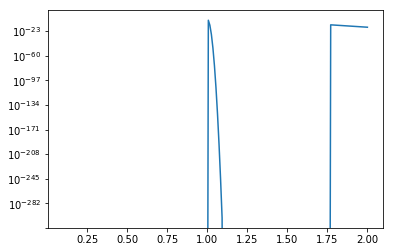

In [160]:
# x = np.linspace( 0.1, 2, 200 )
# y = intensity_gaussian_population( x, 1, 0.05, appx = False )

# plt.semilogy( x, y ) 

In [152]:
# intensity_gaussian_population( np.array([ 1.01, 0.2 ]), 1, 0.01 )

[False False]
[] [] []


array([ 0., -0.])